**Question1**-

Task2-
Showing the LDA Projection Vector on the scatter plot

Task3-Comparing performance of 1-NN Classifier on original and projected data

[[ 1.86189843  2.72296272  0.        ]
 [ 2.23589604 -2.15772062  0.        ]
 [ 1.69281688  0.99589606  0.        ]
 ...
 [ 4.46678886  3.44492577  1.        ]
 [ 5.65897988  4.04334073  1.        ]
 [ 1.98017955  7.15815205  1.        ]]
(2000, 3)


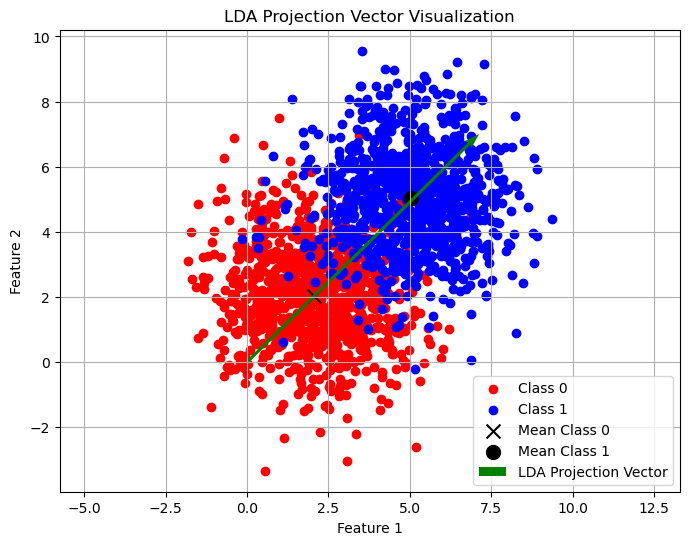

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#reading csv file from github repo
data_url = 'https://raw.githubusercontent.com/anandmishra22/PRML-Spring-2023/main/programmingAssignment/PA-4/data.csv'
df = pd.read_csv(data_url,header=None)
X = df.values
print(X)
print(X.shape)

def ComputeSW(X):
    # Extracting features and labels from the csv file
    features = X[:, :-1].astype(float)
    labels = X[:, -1]

    #Creating an within class Scatar matrix named SW
    SW = np.zeros((features.shape[1], features.shape[1]))

    # Calculating mean vectors for each class
    unique_labels = np.unique(labels)
    for label in unique_labels:
        class_samples = features[labels == label]
        # Calculating the mean vector for the current class
        mean_vector = np.mean(class_samples, axis=0)

        # Calculating the scatter matrix for the current class
        class_SW = np.zeros_like(SW)
        for sample in class_samples:
            deviation = sample - mean_vector
            class_SW += np.outer(deviation, deviation)

        SW += class_SW

    return SW


def ComputeSB(X):
    X_float = X.astype(float)
    # Computing the overall mean of the features
    overall_mean = np.mean(X_float[:, :-1], axis=0)
    # Extracting class 0 and class 1 samples
    class_0_samples = X_float[X_float[:, -1] == 0][:, :-1]
    class_1_samples = X_float[X_float[:, -1] == 1][:, :-1]

    if len(class_0_samples) == 0 or len(class_1_samples) == 0:
        return np.zeros((X.shape[1] - 1, X.shape[1] - 1))

    # Computing the mean of each class
    mean_0 = np.mean(class_0_samples, axis=0)
    mean_1 = np.mean(class_1_samples, axis=0)

    # Computing the deviation of each class mean from the overall mean
    deviation_0 = mean_0 - overall_mean
    deviation_1 = mean_1 - overall_mean

    # Computing the between-class scatter matrix (SB)
    SB = np.outer(deviation_0, deviation_0) + np.outer(deviation_1, deviation_1)

    return SB


def GetLDAProjectionVector(X):
    SW = ComputeSW(X)
    SB = ComputeSB(X)

    # Computing the eigenvalues and eigenvectors of the matrix (SW^-1)*SB
    eigen_values, eigen_vectors = np.linalg.eig(np.dot(np.linalg.inv(SW), SB))
    #Extracting index corresponding to max eigenvalue
    max_index = np.nanargmax(eigen_values)
    # Returning the eigenvector corresponding to the maximum eigenvalue
    return eigen_vectors[:, max_index]

#optimized graph
X_float = X.astype(float)
class_0_samples = X_float[X_float[:, -1] == 0][:, :-1]
class_1_samples = X_float[X_float[:, -1] == 1][:, :-1]

# Computing the mean of each class
mean_0 = np.mean(class_0_samples, axis=0)
mean_1 = np.mean(class_1_samples, axis=0)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(class_0_samples[:, 0], class_0_samples[:, 1], color='red', label='Class 0')
plt.scatter(class_1_samples[:, 0], class_1_samples[:, 1], color='blue', label='Class 1')
plt.scatter(*mean_0, color='black', marker='x', s=100, label='Mean Class 0')
plt.scatter(*mean_1, color='black', marker='o', s=100, label='Mean Class 1')

# Scaling the LDA projection vector for visualization
w=GetLDAProjectionVector(X)
proj_line = w * 10

#LDA direction
plt.quiver(0, 0, proj_line[0], proj_line[1], color='green', scale=1, scale_units='xy', angles='xy', width=0.005, label='LDA Projection Vector')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LDA Projection Vector Visualization')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [2]:
#Task_3
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#One-NN Classifier
class OneNNClassifier:
    def __init__(self):
        pass

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for x_test in X_test:
            nearest_neighbor_index = self.find_nearest_neighbor_index(x_test)
            nearest_neighbor_label = self.y_train[nearest_neighbor_index]
            y_pred.append(nearest_neighbor_label)
        return np.array(y_pred)

    def find_nearest_neighbor_index(self, x_test):
        min_distance = float('inf')
        nearest_neighbor_index = None
        for i, x_train in enumerate(self.X_train):
            distance = np.linalg.norm(x_test - x_train)
            if distance < min_distance:
                min_distance = distance
                nearest_neighbor_index = i
        return nearest_neighbor_index

# Loading the dataset
data_url = 'https://raw.githubusercontent.com/anandmishra22/PRML-Spring-2023/main/programmingAssignment/PA-4/data.csv'
df = pd.read_csv(data_url,header=None)

# Extracting features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and test 1-NN classifier on the original data
knn= OneNNClassifier()
knn.fit(X_train, y_train)
predictions_original = knn.predict(X_test)
accuracy_original = accuracy_score(y_test, predictions_original)

# Performing (LDA) for feature projection
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Train and test 1-NN classifier on the LDA projected data
knn_lda = OneNNClassifier()
knn_lda.fit(X_train_lda, y_train)
predictions_lda = knn_lda.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test, predictions_lda)

# Printing accuracies
print(f'Accuracy with original data: {accuracy_original}')
print(f'Accuracy with LDA projected data: {accuracy_lda}')


Accuracy with original data: 0.8925
Accuracy with LDA projected data: 0.91


 **QUESTION-2**

 In This,we have to use the technique of Naive Bayes to do analysis on the given dataset(i.e weather conditions and possibility of play) and have to calculate different parameters like Priori ,Likelihood,Posterior Probabilities and finally make predictions on the test samples.

 Also,have to repeat all calculations after doing Laplace Smoothing

,Outlook,Temp,Humidity,Windy,Play
0,Rainy,Hot,High,f,no
1,Rainy,Hot,High,t,no
2,Overcast,Hot,High,f,yes
3,Sunny,Mild,High,f,yes
4,Sunny,Cool,Normal,f,yes
5,Sunny,Cool,Normal,t,no
6,Overcast,Cool,Normal,t,yes
7,Rainy,Mild,High,f,no
8,Rainy,Cool,Normal,f,yes
9,Sunny,Mild,Normal,f,yes


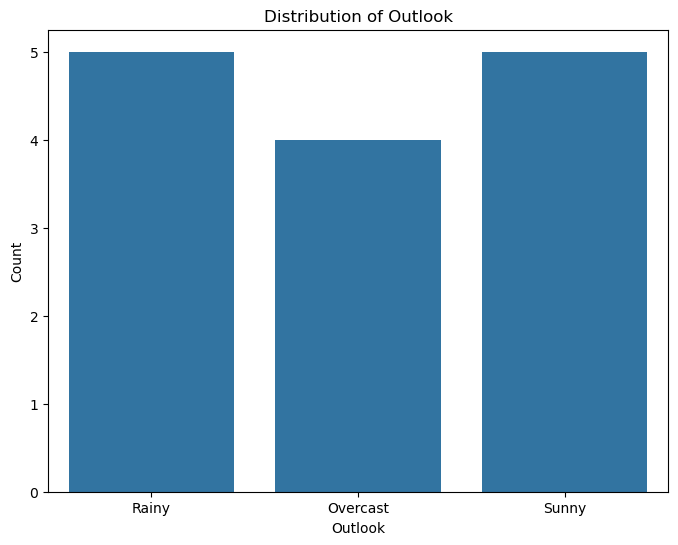

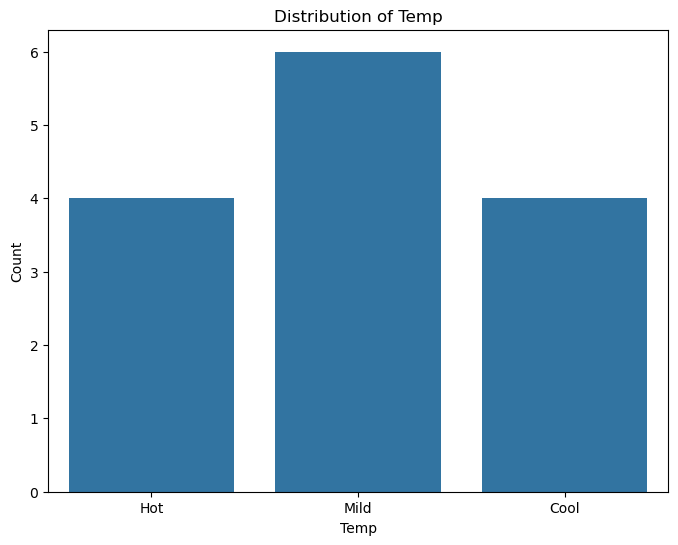

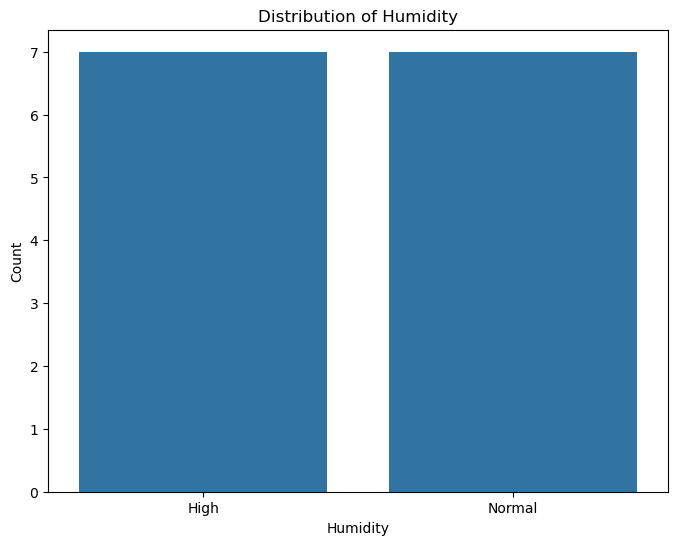

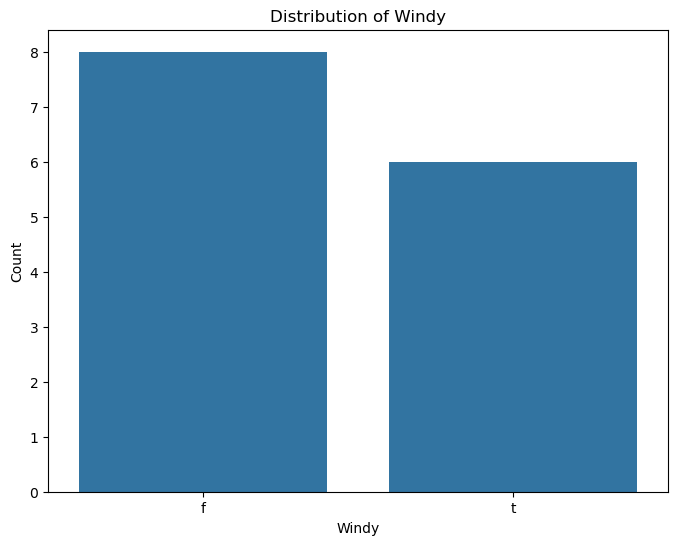

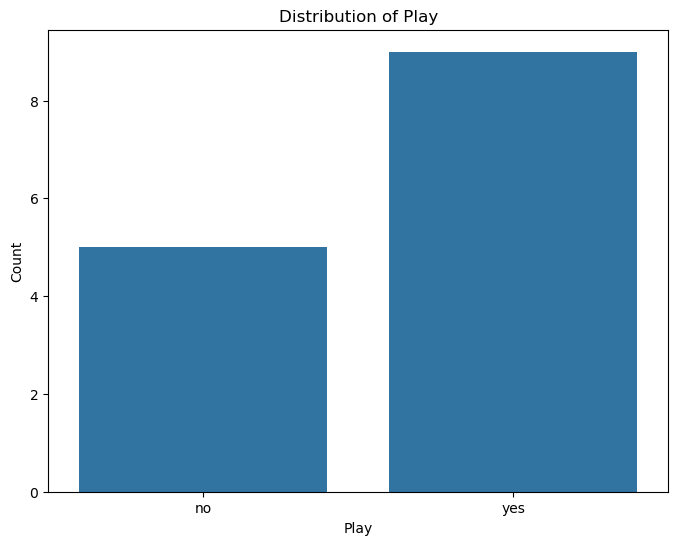

Train set:


,Outlook,Temp,Humidity,Windy,Play
6,Overcast,Cool,Normal,t,yes
11,Overcast,Mild,High,t,yes
10,Rainy,Mild,Normal,t,yes
12,Overcast,Hot,Normal,f,yes
13,Sunny,Mild,High,t,no
9,Sunny,Mild,Normal,f,yes
1,Rainy,Hot,High,t,no
0,Rainy,Hot,High,f,no
8,Rainy,Cool,Normal,f,yes
2,Overcast,Hot,High,f,yes



Test set:


,Outlook,Temp,Humidity,Windy,Play
4,Sunny,Cool,Normal,f,yes
7,Rainy,Mild,High,f,no


Prior Probabilities:
P(Play=yes): 0.6666666666666666
P(Play=no): 0.3333333333333333

Likelihood Probabilities:
P(Outlook=Overcast|Play=yes): 0.5
P(Outlook=Rainy|Play=yes): 0.25
P(Outlook=Sunny|Play=yes): 0.25
P(Outlook=Rainy|Play=no): 0.5
P(Outlook=Sunny|Play=no): 0.5
P(Temp=Cool|Play=yes): 0.25
P(Temp=Hot|Play=yes): 0.25
P(Temp=Mild|Play=yes): 0.5
P(Temp=Cool|Play=no): 0.25
P(Temp=Hot|Play=no): 0.5
P(Temp=Mild|Play=no): 0.25
P(Humidity=High|Play=yes): 0.375
P(Humidity=Normal|Play=yes): 0.625
P(Humidity=High|Play=no): 0.75
P(Humidity=Normal|Play=no): 0.25
P(Windy=f|Play=yes): 0.625
P(Windy=t|Play=yes): 0.375
P(Windy=f|Play=no): 0.25
P(Windy=t|Play=no): 0.75

Posterior Probabilities for Testing Split:
Test Sample 1:
P(Play=yes|data): 0.8620689655172413
P(Play=no|data): 0.13793103448275862
Test Sample 2:
P(Play=yes|data): 0.7142857142857143
P(Play=no|data): 0.2857142857142857

Predictions:
Test Sample 1: Predicted Play = yes
Test Sample 2: Predicted Play = yes

Likelihood Probabilities w

In [3]:
#Loading the data
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
url = "https://raw.githubusercontent.com/anandmishra22/PRML-Spring-2023/main/programmingAssignment/PA-4/naive_bayes.csv"
data = pd.read_csv(url)
# Displaying the dataset
display(data)
# Plotting categorical distributions
categorical_features = ['Outlook', 'Temp', 'Humidity', 'Windy', 'Play']
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=feature)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

#Task_0
# Splitting dataset into train and test sets
train_set, test_set = train_test_split(data, test_size=2, random_state=29)
print("Train set:")
display(train_set)
print("\nTest set:")
display(test_set)

#Task1
# Calculating prior probabilities
prior_counts = train_set['Play'].value_counts()
total_samples = prior_counts.sum()

p_play_yes = prior_counts.get('yes', 0) / total_samples
p_play_no = prior_counts.get('no', 0) / total_samples

print("Prior Probabilities:")
print("P(Play=yes):", p_play_yes)
print("P(Play=no):", p_play_no)

#Task2
# Calculating likelihood probabilities
likelihood_probabilities = {}

for feature in train_set.columns[:-1]:
    for category in train_set['Play'].unique():
        subset = train_set[train_set['Play'] == category]
        counts = subset.groupby(feature).size()
        total_category = subset.shape[0]

        for value, count in counts.items():
            likelihood_probabilities[(feature, value, category)] = count / total_category

print("\nLikelihood Probabilities:")
for key, value in likelihood_probabilities.items():
    print(f"P({key[0]}={key[1]}|Play={key[2]}): {value}")


#Task3
# Calculating posterior probabilities for testing split
posterior_probabilities = []

for index, row in test_set.iterrows():
    posterior_yes = p_play_yes
    posterior_no = p_play_no
    for feature in test_set.columns[:-1]:
        feature_value = row[feature]

        # Handling missing likelihood probabilities
        likelihood_yes = likelihood_probabilities.get((feature, feature_value, 'yes'), 1e-6)
        likelihood_no = likelihood_probabilities.get((feature, feature_value, 'no'), 1e-6)

        posterior_yes *= likelihood_yes
        posterior_no *= likelihood_no

    # Normalizing the posterior probabilities
    sum_posterior = posterior_yes + posterior_no
    posterior_yes /= sum_posterior
    posterior_no /= sum_posterior

    posterior_probabilities.append(('yes', posterior_yes, 'no', posterior_no))

print("\nPosterior Probabilities for Testing Split:")
for i, result in enumerate(posterior_probabilities):
    print(f"Test Sample {i+1}:")
    print("P(Play=yes|data):", result[1])
    print("P(Play=no|data):", result[3])



#Task4
# Making predictions
predictions = ['yes' if result[1] > result[3] else 'no' for result in posterior_probabilities]
print("\nPredictions:")
for i, prediction in enumerate(predictions):
    print(f"Test Sample {i+1}: Predicted Play = {prediction}")

#Task5
# Laplace smoothing parameter
alpha = 1
# Calculateing likelihood probabilities with Laplace smoothing
likelihood_probabilities_smoothed = {}

for feature in train_set.columns[:-1]:
    for category in train_set['Play'].unique():
        subset = train_set[train_set['Play'] == category]
        counts = subset.groupby(feature).size()
        total_category = subset.shape[0]
        total_unique_values = len(train_set[feature].unique())

        for value in train_set[feature].unique():
            count = counts.get(value, 0)
            likelihood_probabilities_smoothed[(feature, value, category)] = (count + alpha) / (total_category + alpha * total_unique_values)

print("\nLikelihood Probabilities with Laplace Smoothing:")
for key, value in likelihood_probabilities_smoothed.items():
    print(f"P({key[0]}={key[1]}|Play={key[2]}): {value}")

# Calculating posterior probabilities for testing split with Laplace smoothing
posterior_probabilities_smoothed = []

# Calculating prior counts for Laplace smoothing
play_yes_count = train_set['Play'].value_counts().get('yes', 0)
play_no_count = train_set['Play'].value_counts().get('no', 0)

for index, row in test_set.iterrows():
    posterior_yes = p_play_yes
    posterior_no = p_play_no
    for feature in test_set.columns[:-1]:
        feature_value = row[feature]

        # Using Laplace smoothed likelihood probabilities
        likelihood_yes = likelihood_probabilities_smoothed.get((feature, feature_value, 'yes'), alpha / (play_yes_count + alpha * len(train_set[feature].unique())))
        likelihood_no = likelihood_probabilities_smoothed.get((feature, feature_value, 'no'), alpha / (play_no_count + alpha * len(train_set[feature].unique())))

        posterior_yes *= likelihood_yes
        posterior_no *= likelihood_no

    # Normalizing the posterior probabilities
    sum_posterior = posterior_yes + posterior_no
    posterior_yes /= sum_posterior
    posterior_no /= sum_posterior

    posterior_probabilities_smoothed.append(('yes', posterior_yes, 'no', posterior_no))

print("\nPosterior Probabilities for Testing Split with Laplace Smoothing:")
for i, result in enumerate(posterior_probabilities_smoothed):
    print(f"Test Sample {i+1}:")
    print("P(Play=yes|data):", result[1])
    print("P(Play=no|data):", result[3])

# Making predictions with Laplace smoothed probabilities
predictions_smoothed = []

for result in posterior_probabilities_smoothed:
    # Check which class has higher posterior probability
    if result[1] > result[3]:
        predictions_smoothed.append('yes')
    else:
        predictions_smoothed.append('no')

# Printing predictions with Laplace smoothing
print("\nPredictions with Laplace Smoothing:")
for i, prediction in enumerate(predictions_smoothed):
    print(f"Test Sample {i+1}: Predicted Play = {prediction}")

# Checking if the predictions match the ground truth
ground_truth = test_set['Play'].values
for i, (prediction, truth) in enumerate(zip(predictions_smoothed, ground_truth)):
    if prediction != truth:
        print(f"Test Sample {i+1}: Predicted Play = {prediction} (Ground Truth = {truth})")

#predictions
def get_predictions(posterior_probabilities):
    predictions = []
    for result in posterior_probabilities:
        if result[1] > result[3]:
            predictions.append('yes')
        else:
            predictions.append('no')
    return predictions
# for normal data
predictions_normal = get_predictions(posterior_probabilities)
# smoothed data
predictions_smoothed = get_predictions(posterior_probabilities_smoothed)

from sklearn.metrics import accuracy_score, confusion_matrix

#truth labels
ground_truth = test_set['Play'].values

# accuracy for normal data
accuracy_normal = accuracy_score(ground_truth, predictions_normal)

#confusion matrix for normal data
conf_matrix_normal = confusion_matrix(ground_truth, predictions_normal, labels=['yes', 'no'])

# accuracy for smoothed data
accuracy_smoothed = accuracy_score(ground_truth, predictions_smoothed)

#  confusion matrix for smoothed data
conf_matrix_smoothed = confusion_matrix(ground_truth, predictions_smoothed, labels=['yes', 'no'])

# Printing accuracy for both cases
print("Accuracy for Normal Data:", accuracy_normal)
print("Accuracy for Smoothed Data:", accuracy_smoothed)

# Printing confusion matrix for normal data
print("\nConfusion Matrix for Normal Data:")
print(conf_matrix_normal)

# Printing confusion matrix for smoothed data
print("\nConfusion Matrix for Smoothed Data:")
print(conf_matrix_smoothed)

